In [1]:
from phi.flow import *

In [2]:
N = 128 
STEPS = 32 
DT = 1./STEPS 
NU = 0.01/np.pi

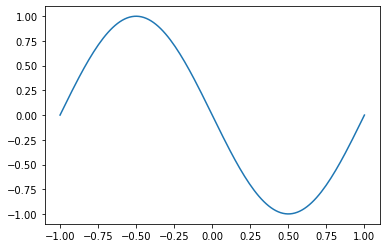

In [3]:
import pylab

div_num = 128
x_val = np.linspace(-1,1,div_num)
sinx_val = np.asarray( [-np.sin(np.pi * x) * 1. for x in np.linspace(-1,1,div_num)] ) # 1D numpy ˓→array 
plot_sinx = pylab.plot(x_val,sinx_val)


In [4]:
# initialization of velocities 
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) * 1. for x in np.linspace(-1,1,N)] ) # 1D numpy ˓→array 
INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor

In [5]:
velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box[-1:1]) 
#velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box[-1:1]) # random init
print("Velocity tensor shape: " + format( velocity.shape )) # == velocity.values.shape 
print("Velocity tensor type: " + format( type(velocity.values) )) 
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy()[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phi.math._tensors.CollapsedTensor'>
Velocity tensor entries 10 to 14: [0.47480196 0.51774486 0.55942075 0.59972764 0.6385669 ]


In [6]:
velocities = [velocity] 
age = 0. 
for i in range(STEPS): 
    v1 = diffuse.explicit(velocities[-1], NU, DT)
    v2 = advect.semi_lagrangian(v1, v1, DT) 
    age += DT 
    velocities.append(v2)
    print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy()[0:5] ))

New velocity content at t=0.03125: [0.00031444 0.04459282 0.08903833 0.13335665 0.17744303]
New velocity content at t=0.0625: [0.00059091 0.04066949 0.08112327 0.12153511 0.16179581]
New velocity content at t=0.09375: [0.00083572 0.03743165 0.07455994 0.11171146 0.14876668]
New velocity content at t=0.125: [0.00105358 0.03471146 0.06902399 0.10341052 0.13774079]
New velocity content at t=0.15625: [0.00124814 0.03239238 0.06428812 0.09629846 0.12828285]
New velocity content at t=0.1875: [0.00142233 0.03039075 0.06018828 0.0901334  0.1200764 ]
New velocity content at t=0.21875: [0.00157854 0.0286448  0.05660281 0.08473542 0.11288534]
New velocity content at t=0.25: [0.00171878 0.02710796 0.05343935 0.07996802 0.10652983]
New velocity content at t=0.28125: [0.00184472 0.02574436 0.0506268  0.07572553 0.10087056]
New velocity content at t=0.3125: [0.0019578  0.02452604 0.04810915 0.07192476 0.09579783]
New velocity content at t=0.34375: [0.00205929 0.0234307  0.0458419  0.06849945 0.091223

In [7]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector" 
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays

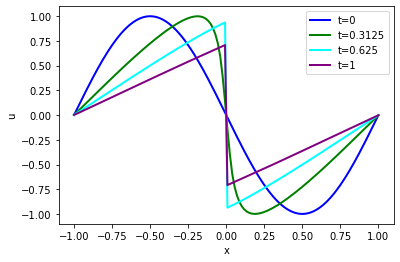

In [8]:
import pylab

fig = pylab.figure().gca() 
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue', label= "t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label= "t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan', label= "t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label= "t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

In [9]:
def show_state(a, title): 
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see 
    # (could also be done with more evaluations of network) 
    a=np.expand_dims(a, axis=2) 
    for i in range(4): 
        a = np.concatenate( [a,a] , axis=2)
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    #print("Resulting image size" +format(a.shape))
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5)) 
    im = axes.imshow(a, origin='upper', cmap='inferno') 
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)

In [10]:
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 )

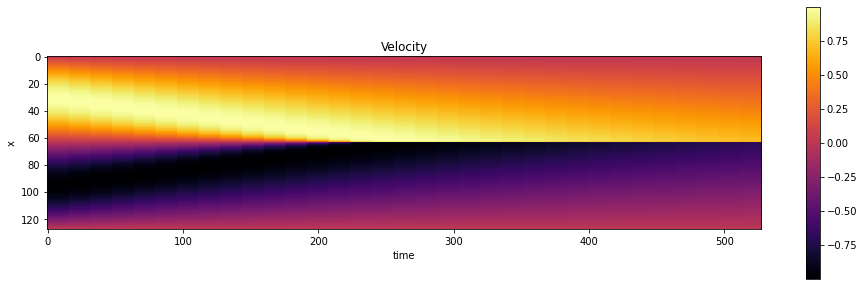

In [11]:
# save for comparison with reconstructions later on 
import os; os.makedirs("./temp",exist_ok=True) 
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,STEPS+1])) 
# ˓→remove batch & channel dimension 
show_state(vels_img, "Velocity")